In [395]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
ASOS = pd.read_csv("ASOS.Ulsan.6hr.1980-2017.csv")
ASOS.columns = list(map(lambda x: re.sub(" \[.*\]","",x) ,ASOS.columns))
ASOS.TIME = ASOS.TIME.map(lambda x:datetime.strptime(str(x),"%Y%m%d%H"))
ASOS['SECONDS'] = ASOS.TIME.map(lambda x:int((x- datetime(x.year,1,1,0,0)).total_seconds()))
ASOS['TIME_IN_A_DAY'] = ASOS.TIME.map(lambda x:x.hour)
seconds_order = {j:i for i,j in enumerate(sorted(ASOS.SECONDS.unique()))}
ASOS['SECONDS_ORDER'] = ASOS.SECONDS.map(lambda x:seconds_order[x])
ASOS['TOTAL_SECONDS'] = ASOS.TIME.map(lambda x: int((x-ASOS.TIME.min()).total_seconds()))
total_seconds_order = {j:i for i,j in enumerate(sorted(ASOS.TOTAL_SECONDS.unique()))}
ASOS['TOTAL_SECONDS_ORDER'] = ASOS.TOTAL_SECONDS.map(lambda x:total_seconds_order[x])
ASOS["MONTH"] = ASOS.TIME.map(lambda x:x.month)
ASOS["YEAR"] = ASOS.TIME.map(lambda x:x.year)

In [365]:
cols = ["T_seq","WIND SPEED","HUMIDITY","SEA-LEVEL PRESSURE","PRECIPITATION"]
_ASOS = ASOS[(ASOS.TIME_IN_A_DAY == 12) & (ASOS.MONTH >= 7) & (ASOS.MONTH <= 9) & (ASOS.YEAR != ASOS.YEAR.max())]
_ASOS["T_seq"] = list(range(len(_ASOS)))
kernel= ConstantKernel(1.0, (1e-3, 1e3))*(RBF([1. for _ in cols], (1e-5, 10))+ConstantKernel(1.0, (1e-3, 1e3)) + DotProduct()) #RBF([.1, .1, .1, .1, .1, .1], (1e-5, 10))#
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
_X = _ASOS[cols]
_X[cols[1:]] = (_X[cols[1:]]  - _X[cols[1:]].min() )/ (_X[cols[1:]].max()  - _X[cols[1:]].min() ) *100
X = np.array(_X)#np.array(_X,dtype=np.float16)
y = np.array(_ASOS.TEMPERATURE)
gp.fit(X, y)

#2.65**2 * RBF(length_scale=[4.03, 10, 10, 10]) + 2.55**2 + DotProduct(sigma_0=14.3) : kernel result

train_size = len(X)


_ASOS = ASOS[(ASOS.TIME_IN_A_DAY == 12) & (ASOS.MONTH >= 7) & (ASOS.MONTH <= 9)]
_ASOS["T_seq"] = list(range(len(_ASOS)))
_X = _ASOS[cols]
_X[cols[1:]] = (_X[cols[1:]]  - _X[cols[1:]].min() )/ (_X[cols[1:]].max()  - _X[cols[1:]].min() ) *100
X = np.array(_X)#np.array(_X,dtype=np.float16)
y = np.array(_ASOS.TEMPERATURE)

y_pred, y_std = gp.predict(X, return_std=True)
y_origin = pd.Series(y)
y_pred = pd.Series(y_pred)
y_origin.to_csv("./y_origin5.csv")
y_pred.to_csv("./y_pred5.csv")
y_origin = pd.read_csv("y_origin.csv",index_col=0,header=None)
y_pred = pd.read_csv("y_pred.csv",index_col=0,header=None)

/Users/yunwoo/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/yunwoo/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


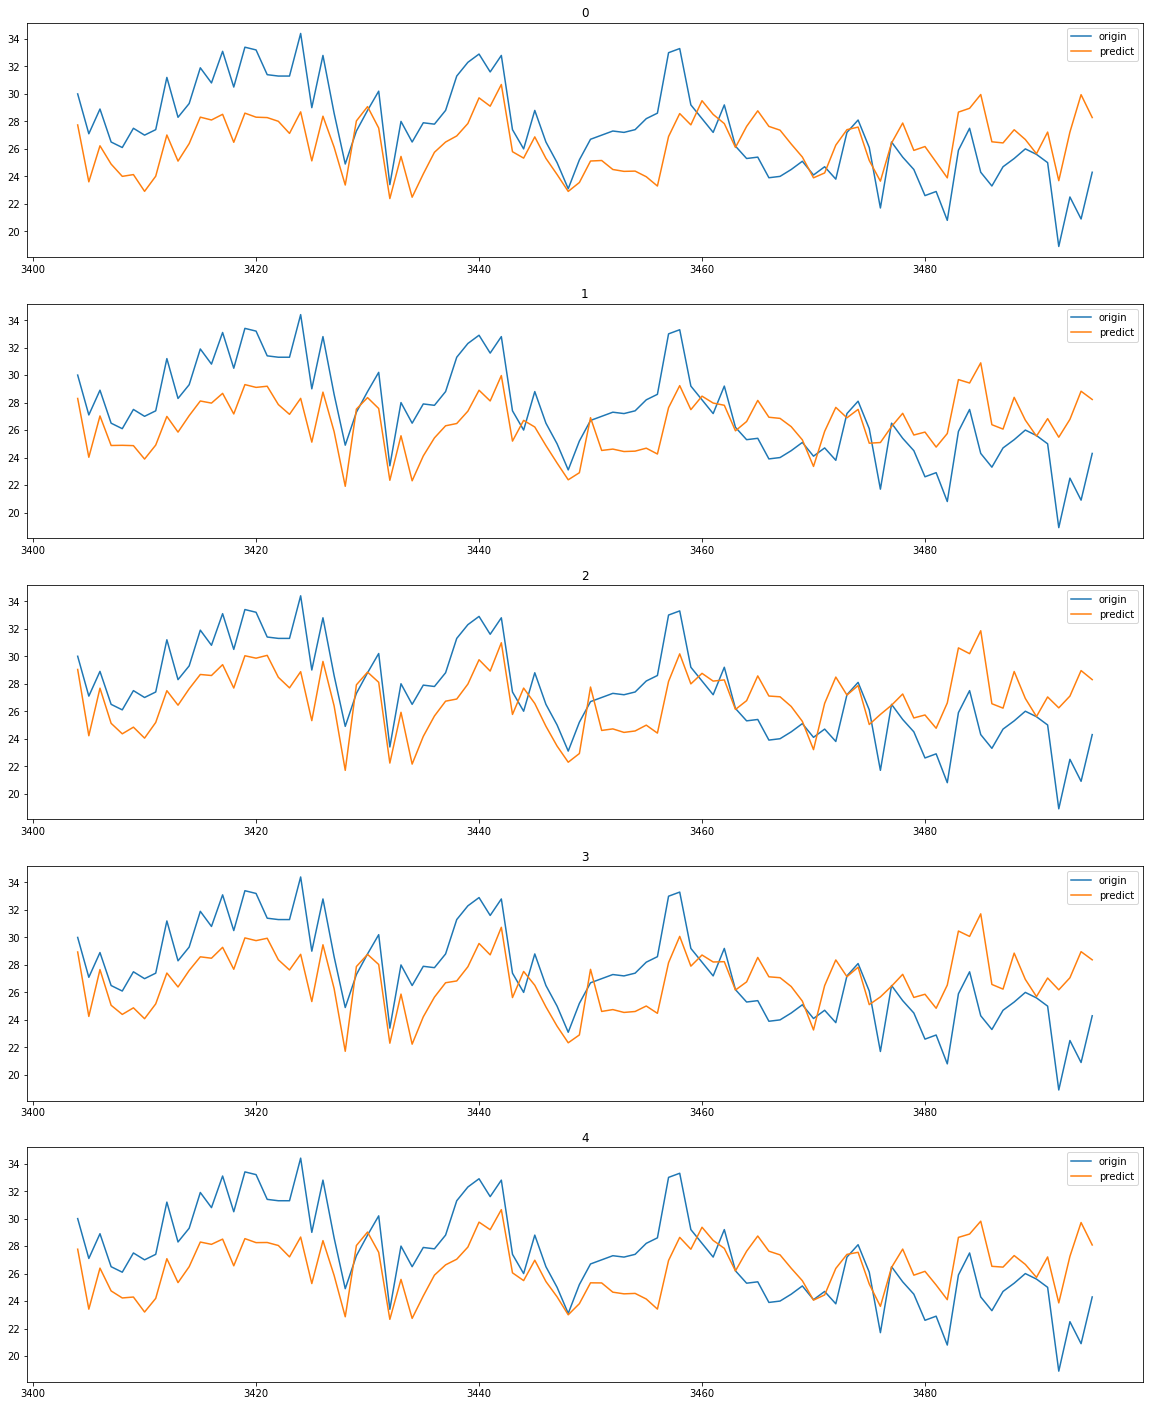

In [413]:
from matplotlib import  pyplot as plt
rslt_s = 5
reuslts = []
fig = plt.figure(figsize=[20,rslt_s*5])
for i in range(rslt_s):
    y_origin = pd.read_csv("y_origin%d.csv"%i,index_col=0,header=None)
    y_pred = pd.read_csv("y_pred%d.csv"%i,index_col=0,header=None)
    ax = fig.add_subplot(rslt_s,1,i+1)
    ax.plot(y_origin[train_size:],label='origin')
    ax.plot(y_pred[train_size:],label='predict')
    ax.set_title("%d"%i)
    ax.legend()
    reuslts.append((y_origin,y_pred))
"""
ax1.plot(y_origin[train_size:],label='origin')
ax1.plot(y_pred[train_size:],label='predict')
ax1.legend()
ax2.plot(y_origin2[train_size:],label='origin')
ax2.plot(y_pred2[train_size:],label='predict')
ax2.legend()
"""
plt.show()

In [418]:
_ASOS = ASOS[(ASOS.TIME_IN_A_DAY == 12) & (ASOS.MONTH >= 7) & (ASOS.MONTH <= 9) & (ASOS.YEAR != ASOS.YEAR.max())]

_ASOS.index = range(len(_ASOS))

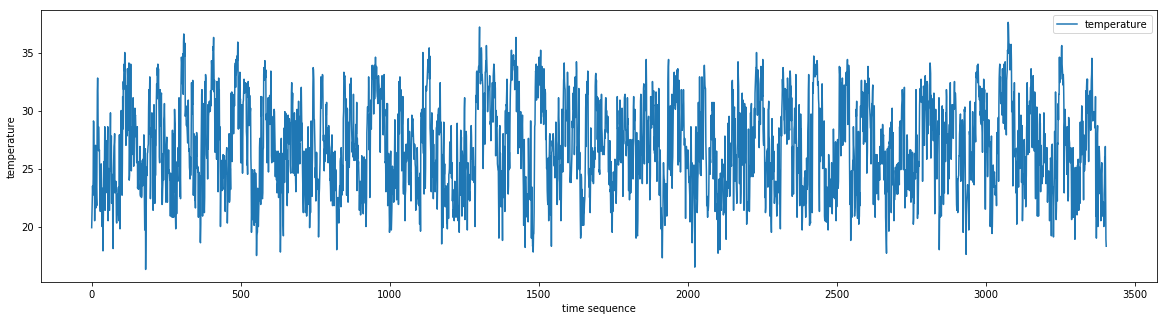

In [419]:
fig = plt.figure(figsize=[20,5])
ax = fig.add_subplot(1,1,1)
ax.plot(_ASOS.TEMPERATURE, label='temperature')
ax.set_xlabel("time sequence")
ax.set_ylabel("temperature")
ax.legend()
plt.show()

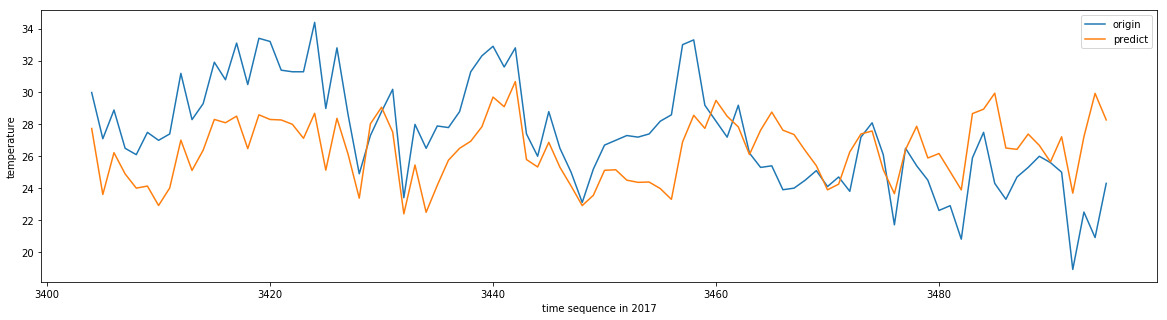

In [420]:
fig = plt.figure(figsize=[20,5])
ax = fig.add_subplot(1,1,1)
y_origin = pd.read_csv("y_origin0.csv",index_col=0,header=None)
y_pred = pd.read_csv("y_pred0.csv",index_col=0,header=None)
ax.plot(y_origin[train_size:],label='origin')
ax.plot(y_pred[train_size:],label='predict')
ax.set_xlabel("time sequence in 2017")
ax.set_ylabel("temperature")
ax.legend()
plt.show()